In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/MyDrive/Metrics Baseline/Data/results_resnet/" ./

Mounted at /content/drive


In [2]:
!pip install xplique

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.4/191.4 kB 1.7 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, **kwargs):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

import seaborn as sns
sns.set(font_scale=2)

<ipython-input-3-255f4ac980e9>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys

def get_alpha_cmap(cmap):
  if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)
  else:
    c = np.array((cmap[0]/255.0, cmap[1]/255.0, cmap[2]/255.0))

    cmax = colorsys.rgb_to_hls(*c)
    cmax = np.array(cmax)
    cmax[-1] = 1.0

    cmax = np.clip(np.array(colorsys.hls_to_rgb(*cmax)), 0, 1)
    #cmax = np.clip(c * 1.2, 0, 1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c,cmax])

  alpha_cmap = cmap(np.arange(256))
  alpha_cmap[:,-1] = np.linspace(0, 0.85, 256)
  alpha_cmap = ListedColormap(alpha_cmap)

  return alpha_cmap

slack_blue  = get_alpha_cmap((54, 197, 240))
slack_green = get_alpha_cmap((46, 182, 125) )
slack_red   = get_alpha_cmap((210, 40, 95))
slack_yellow = get_alpha_cmap((236, 178, 46))
slack_violet = get_alpha_cmap((84, 25, 85))

google_blue = get_alpha_cmap((66, 133, 244))
google_red = get_alpha_cmap((219, 68, 55))
google_yellow= get_alpha_cmap((244, 180, 0))
google_green = get_alpha_cmap((15, 157, 88))

deep_purple = get_alpha_cmap((103, 58, 183))
pink = get_alpha_cmap((236, 64, 122))
anthracite = get_alpha_cmap((13, 13, 21))

brown = get_alpha_cmap((121, 85, 72))

In [5]:
import os

results = {}

for p in os.listdir("/content/results_resnet"):
  if "ood_" not in p and "removal" not in p:
    data = np.load('/content/results_resnet/'+p, allow_pickle=True)
    data = [(m, d, i, u) for m, d, i, u in data if 'Guided' not in m]
    deletions = [(m.replace('resnet50_', '').replace('.npy', ''), d) for m, d, i, _ in data]
    insertions = [(m.replace('resnet50_', '').replace('.npy', ''), i) for m, d, i, _ in data]
    methods = [m.replace('resnet50_', '').replace('.npy', '') for m, d, i, _ in data]
    results[p.replace('.npy', '')] = (deletions, insertions)

baselines = list(results.keys())

In [6]:
method_to_id = {m : i for m, i in enumerate(methods)}
method_to_id, baselines

({0: 'Occlusion',
  1: 'SobolAttributionMethod',
  2: 'Saliency',
  3: 'IntegratedGradients',
  4: 'VarGrad',
  5: 'SmoothGrad',
  6: 'SquareGrad',
  7: 'GradCAMPP',
  8: 'DeconvNet',
  9: 'GradCAM',
  10: 'GradientInput',
  11: 'Rise',
  12: 'HsicAttributionMethod'},
 ['zero',
  'scramble_phase',
  'random_color',
  'uniform',
  'local_mean',
  'scramble_amplitude',
  'normal',
  'permutation',
  'local_permutation',
  'mean',
  'median'])

In [7]:
results

{'zero': ([('Occlusion', '0.7082298398017883'),
   ('SobolAttributionMethod', '0.7286586761474609'),
   ('Saliency', '0.7749654054641724'),
   ('IntegratedGradients', '0.7514544725418091'),
   ('VarGrad', '0.7514256238937378'),
   ('SmoothGrad', '0.741315484046936'),
   ('SquareGrad', '0.7519910335540771'),
   ('GradCAMPP', '0.7435828447341919'),
   ('DeconvNet', '0.7642708420753479'),
   ('GradCAM', '0.7732097506523132'),
   ('GradientInput', '0.769544780254364'),
   ('Rise', '0.7515383958816528'),
   ('HsicAttributionMethod', '0.7124066352844238')],
  [('Occlusion', '0.8358743786811829'),
   ('SobolAttributionMethod', '0.9157744646072388'),
   ('Saliency', '0.8621150851249695'),
   ('IntegratedGradients', '0.8942121267318726'),
   ('VarGrad', '0.9183717966079712'),
   ('SmoothGrad', '0.903426468372345'),
   ('SquareGrad', '0.9185979962348938'),
   ('GradCAMPP', '0.9259351491928101'),
   ('DeconvNet', '0.8491586446762085'),
   ('GradCAM', '0.9245476722717285'),
   ('GradientInput', '0

### Check whether the metric from the German team actually makes sense

In [8]:
from typing import Tuple, List, Dict
from functools import reduce

def compute_nobaseline_metric(all_results: Dict, method_name: str):
  """The metric created by the German team (their_metric = Insertion - Deletion)"""
  assert method_name in method_to_id.values()
  method_results = {}
  for k in all_results.keys():
    deletion, insertion = all_results[k]
    deletion_method = max([float(d[1]) if d[0] == method_name else 0. for d in deletion])
    insertion_method = max([float(i[1]) if i[0] == method_name else 0. for i in insertion])
    method_results[k] = insertion_method - deletion_method
  nobaseline_metric = list(method_results.values())

  return nobaseline_metric

In [9]:
# Use the function to compute this new metric for each method
m = compute_nobaseline_metric(results, method_name="Occlusion")
m

[0.12764453887939453,
 0.14520925283432007,
 0.13624203205108643,
 0.14924204349517822,
 0.1376936435699463,
 0.14391309022903442,
 0.147233247756958,
 0.14442181587219238,
 0.11975610256195068,
 0.12604063749313354,
 0.12338358163833618]

In [10]:
german_metrics = {k: compute_nobaseline_metric(results, k) for k in method_to_id.values()}
german_metrics

{'Occlusion': [0.12764453887939453,
  0.14520925283432007,
  0.13624203205108643,
  0.14924204349517822,
  0.1376936435699463,
  0.14391309022903442,
  0.147233247756958,
  0.14442181587219238,
  0.11975610256195068,
  0.12604063749313354,
  0.12338358163833618],
 'SobolAttributionMethod': [0.18711578845977783,
  0.1779712438583374,
  0.19202208518981934,
  0.19915175437927246,
  0.17052984237670898,
  0.1850581169128418,
  0.20217567682266235,
  0.18365031480789185,
  0.18365025520324707,
  0.18580740690231323,
  0.1851990818977356],
 'Saliency': [0.08714967966079712,
  0.10106021165847778,
  0.11123496294021606,
  0.1200031042098999,
  0.1151965856552124,
  0.11804640293121338,
  0.12887215614318848,
  0.11539071798324585,
  0.10996949672698975,
  0.09136360883712769,
  0.09383159875869751],
 'IntegratedGradients': [0.14275765419006348,
  0.1338104009628296,
  0.14826178550720215,
  0.1975002884864807,
  0.1266864538192749,
  0.1439325213432312,
  0.19442319869995117,
  0.15112745761

In [11]:
def sort_dict_by_list_index(data: Dict[str, List[float]], index: int) -> List[str]:
    """
    Sort the keys of a dictionary based on the values at a specific index in their corresponding lists.

    Args:
    data (Dict[str, List[float]]): A dictionary with keys as strings and values as lists of floats.
    index (int): The index in the lists to sort the keys by.

    Returns:
    List[str]: A list of keys sorted based on the values at the specified index in their lists.

    Raises:
    ValueError: If the specified index is out of the range for the list elements.
    """

    # Check if the index is valid for all elements
    if any(index >= len(v) for v in data.values()):
        raise ValueError("Index is out of range for one or more list values.")

    # Sorting the dictionary keys based on the value at the specified index in their lists
    sorted_keys = sorted(data, key=lambda k: data[k][index], reverse=True)

    return sorted_keys

In [12]:
# Test the different rankings
print(sort_dict_by_list_index(german_metrics, 0))
print(sort_dict_by_list_index(german_metrics, 1))

['HsicAttributionMethod', 'SobolAttributionMethod', 'GradCAMPP', 'Rise', 'VarGrad', 'SquareGrad', 'SmoothGrad', 'GradCAM', 'IntegratedGradients', 'Occlusion', 'GradientInput', 'Saliency', 'DeconvNet']
['HsicAttributionMethod', 'SquareGrad', 'VarGrad', 'GradCAMPP', 'Rise', 'SobolAttributionMethod', 'SmoothGrad', 'Occlusion', 'GradCAM', 'IntegratedGradients', 'DeconvNet', 'GradientInput', 'Saliency']


In [13]:
for i in range(len(german_metrics["Occlusion"])):
  print(sort_dict_by_list_index(german_metrics, i))

['HsicAttributionMethod', 'SobolAttributionMethod', 'GradCAMPP', 'Rise', 'VarGrad', 'SquareGrad', 'SmoothGrad', 'GradCAM', 'IntegratedGradients', 'Occlusion', 'GradientInput', 'Saliency', 'DeconvNet']
['HsicAttributionMethod', 'SquareGrad', 'VarGrad', 'GradCAMPP', 'Rise', 'SobolAttributionMethod', 'SmoothGrad', 'Occlusion', 'GradCAM', 'IntegratedGradients', 'DeconvNet', 'GradientInput', 'Saliency']
['HsicAttributionMethod', 'SmoothGrad', 'Rise', 'GradCAMPP', 'SquareGrad', 'SobolAttributionMethod', 'GradientInput', 'VarGrad', 'GradCAM', 'IntegratedGradients', 'Occlusion', 'Saliency', 'DeconvNet']
['GradCAMPP', 'HsicAttributionMethod', 'SquareGrad', 'SobolAttributionMethod', 'IntegratedGradients', 'VarGrad', 'Rise', 'SmoothGrad', 'GradientInput', 'GradCAM', 'Occlusion', 'Saliency', 'DeconvNet']
['SmoothGrad', 'HsicAttributionMethod', 'SobolAttributionMethod', 'SquareGrad', 'VarGrad', 'Rise', 'Occlusion', 'GradCAMPP', 'IntegratedGradients', 'GradCAM', 'Saliency', 'DeconvNet', 'GradientInp

In [14]:
def plot_rankings(data: Dict[str, List[float]]):
    """
    Plot the rankings of dictionary keys based on the values at each index in their corresponding lists.

    Args:
    data (Dict[str, List[float]]): A dictionary with keys as strings and values as lists of floats.

    Raises:
    ValueError: If lists in the dictionary have inconsistent lengths.
    """

    # Validate all lists have the same length
    list_lengths = {len(v) for v in data.values()}
    if len(list_lengths) > 1:
        raise ValueError("All lists in the dictionary must be of the same length.")

    list_length = list_lengths.pop()  # All lists are the same length, take one length sample

    # Prepare data for plotting
    rankings = {key: [] for key in data}  # Dictionary to store rankings for each key

    for idx in range(list_length):
        sorted_keys = sort_dict_by_list_index(data, idx)
        current_ranking = {key: rank for rank, key in enumerate(sorted_keys)}
        for key in data:
            rankings[key].append(current_ranking[key])

    # Initialize the plot
    plt.figure(figsize=(12, 8))

    # Plot each key's rankings across all indices
    for key, ranks in rankings.items():
        plt.plot(range(list_length), ranks, label=key, marker='o', linestyle='-')

    # Configure plot settings
    plt.xlabel('List Index')
    plt.ylabel('Rank')
    plt.title('Ranking of Attribution Methods using SRG')
    plt.xticks(range(list_length))
    # plt.yticks(range(len(data)), sorted(data, key=lambda k: data[k][0]))
    # plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()  # Higher rankings appear higher on the plot
    plt.show()

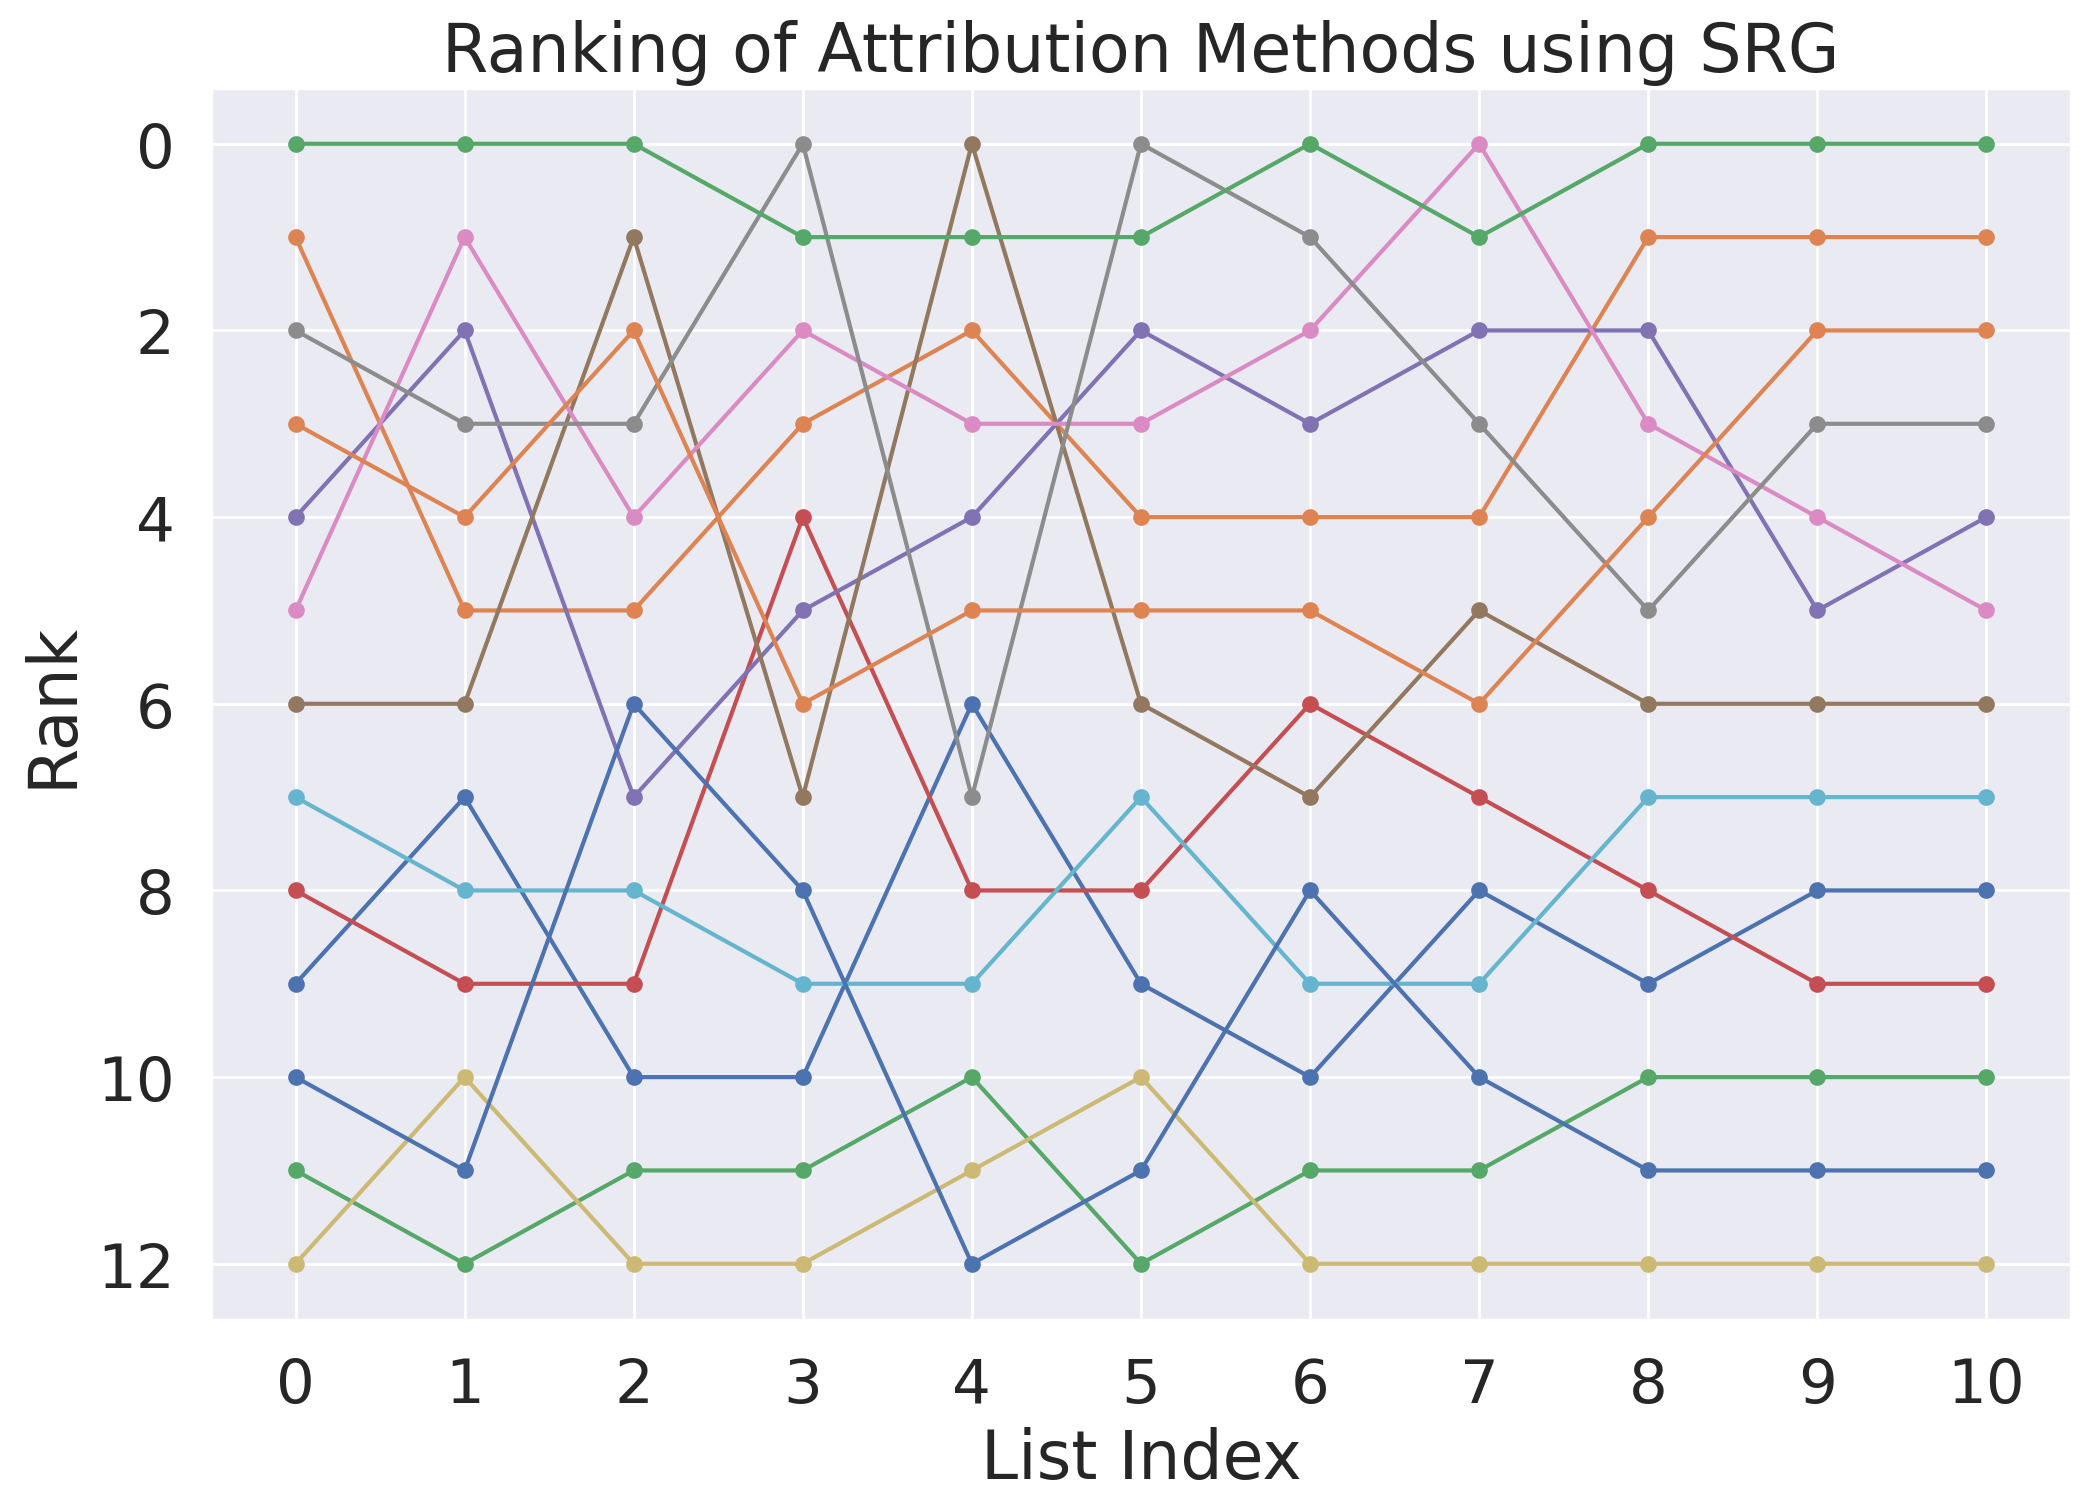

In [15]:
plot_rankings(german_metrics)

## Improve the plot for the paper

In [16]:
def sort_dict_by_list_index(data: Dict[str, List[float]], index: int) -> List[str]:
    """
    Sort the keys of a dictionary based on the values at a specific index in their corresponding lists.

    Args:
    data (Dict[str, List[float]]): A dictionary with keys as strings and values as lists of floats.
    index (int): The index in the lists to sort the keys by.

    Returns:
    List[str]: A list of keys sorted based on the values at the specified index in their lists.

    Raises:
    ValueError: If the specified index is out of the range for the list elements.
    """
    if any(index >= len(v) for v in data.values()):
        raise ValueError("Index is out of range for one or more list values.")

    sorted_keys = sorted(data, key=lambda k: data[k][index])
    return sorted_keys

def plot_rankings(data: Dict[str, List[float]]):
    """
    Plot the rankings of dictionary keys based on the values at each index in their corresponding lists.

    Args:
    data (Dict[str, List[float]]): A dictionary with keys as strings and values as lists of floats.

    Raises:
    ValueError: If lists in the dictionary have inconsistent lengths.
    """

    # Validate all lists have the same length
    list_lengths = {len(v) for v in data.values()}
    if len(list_lengths) > 1:
        raise ValueError("All lists in the dictionary must be of the same length.")

    list_length = list_lengths.pop()  # All lists are the same length, take one length sample

    # Prepare data for plotting
    rankings = {key: [] for key in data}  # Dictionary to store rankings for each key

    for idx in range(list_length):
        sorted_keys = sort_dict_by_list_index(data, idx)
        current_ranking = {key: rank for rank, key in enumerate(sorted_keys)}
        for key in data:
            rankings[key].append(current_ranking[key])

    # Set plot style
    sns.set(style="white")

    # Colors
    colors = [[78, 20, 105], [220, 81, 104], [55, 125, 163], [75, 165, 227], [79, 170, 111], [107, 203, 175]]
    np.random.shuffle(colors)
    colors = np.array(colors) / 255  # Normalize to [0, 1] range for matplotlib

    # Background color
    background_color = np.array([234, 234, 242]) / 255

    # Initialize the plot
    plt.figure(figsize=(12, 8))
    plt.gca().set_facecolor(background_color)

    # Plot each key's rankings across all indices
    for i, (key, ranks) in enumerate(rankings.items()):
        plt.plot(range(list_length), ranks, label=key, marker='o', linestyle='-', color=colors[i % len(colors)])

    # Configure plot settings
    plt.xlabel('List Index', fontsize=14)
    plt.ylabel('Rank', fontsize=14)
    plt.title('Ranking of Attribution Methods using SRG', fontsize=18)
    plt.xticks(range(list_length))
    plt.yticks(range(len(data)))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)
    plt.gca().invert_yaxis()  # Higher rankings appear higher on the plot

    # Remove grid
    plt.grid(False)

    plt.tight_layout()
    plt.show()

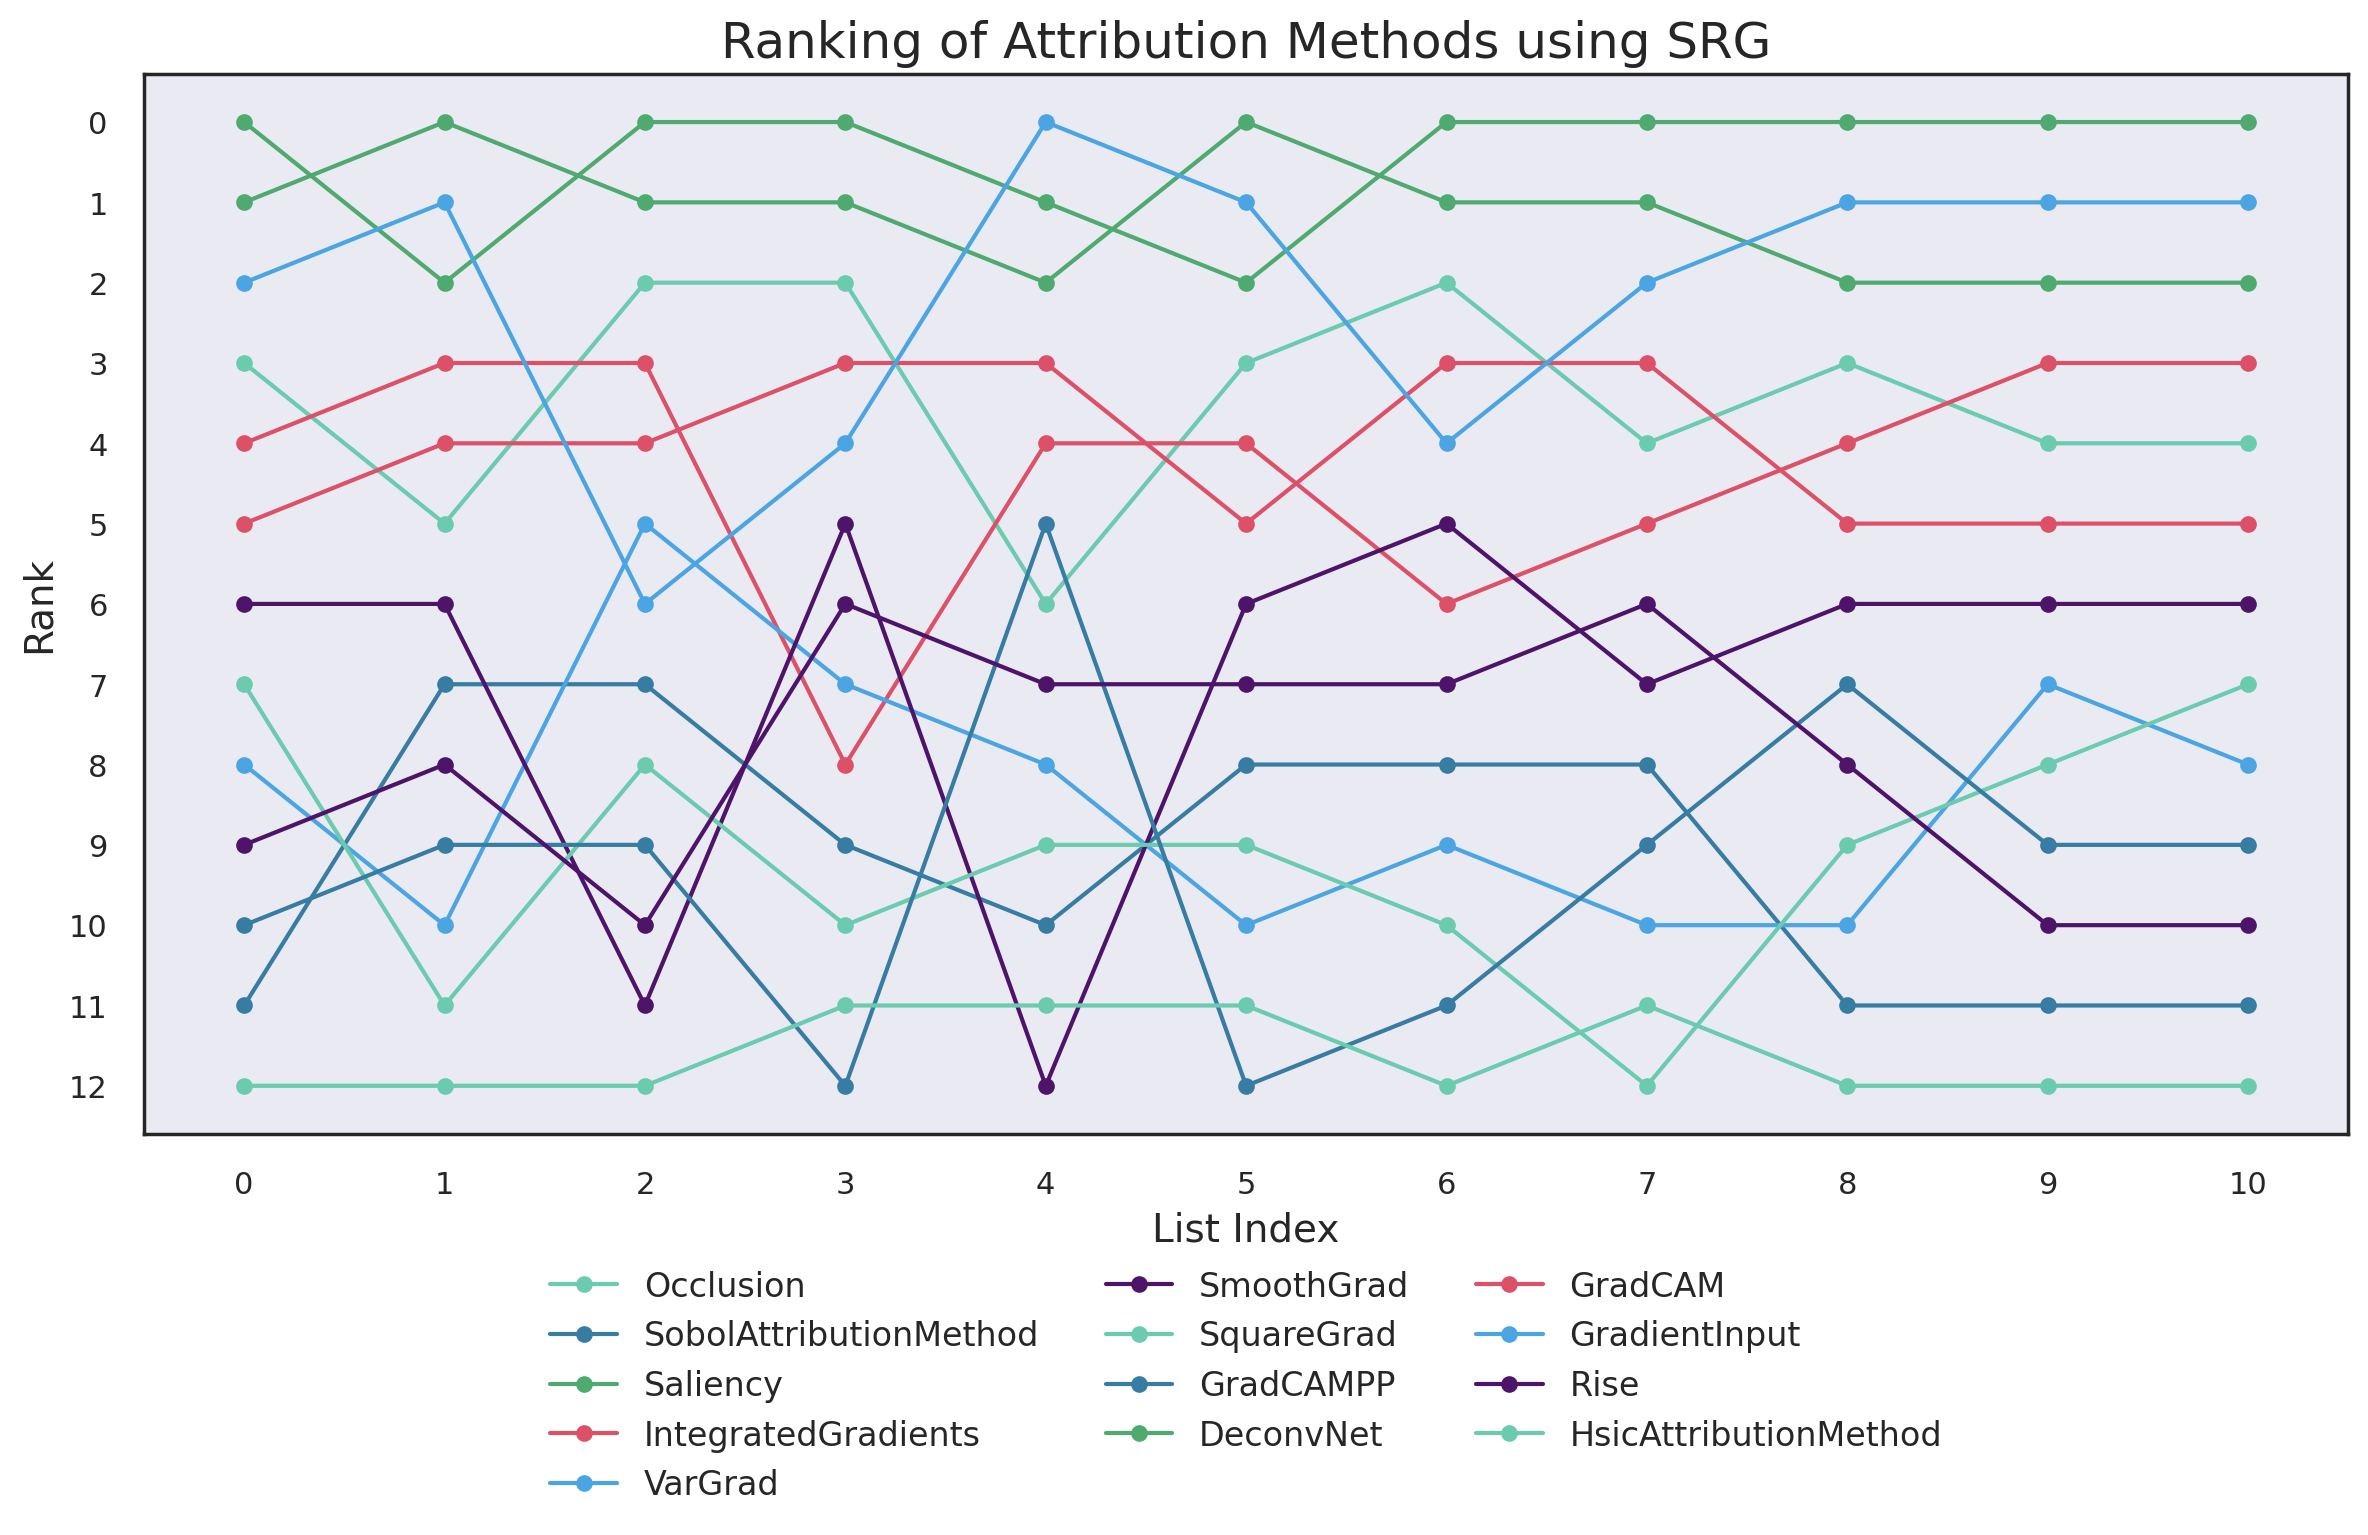

In [17]:
plot_rankings(german_metrics)

In [28]:
def set_size_custom(width, height):
    """ Helper function to set the size of the plot """
    plt.gcf().set_size_inches(width, height)

def sort_dict_by_list_index(data: Dict[str, List[float]], index: int) -> List[str]:
    """
    Sort the keys of a dictionary based on the values at a specific index in their corresponding lists.

    Args:
    data (Dict[str, List[float]]): A dictionary with keys as strings and values as lists of floats.
    index (int): The index in the lists to sort the keys by.

    Returns:
    List[str]: A list of keys sorted based on the values at the specified index in their lists.

    Raises:
    ValueError: If the specified index is out of the range for the list elements.
    """
    if any(index >= len(v) for v in data.values()):
        raise ValueError("Index is out of range for one or more list values.")

    sorted_keys = sorted(data, key=lambda k: data[k][index])
    return sorted_keys

def plot_rankings_custom(data: Dict[str, List[float]]):
    """
    Plot the rankings of dictionary keys based on the values at each index in their corresponding lists.

    Args:
    data (Dict[str, List[float]]): A dictionary with keys as strings and values as lists of floats.

    Raises:
    ValueError: If lists in the dictionary have inconsistent lengths.
    """

    # Validate all lists have the same length
    list_lengths = {len(v) for v in data.values()}
    if len(list_lengths) > 1:
        raise ValueError("All lists in the dictionary must be of the same length.")

    list_length = list_lengths.pop()  # All lists are the same length, take one length sample

    # Prepare data for plotting
    rankings = {key: [] for key in data}  # Dictionary to store rankings for each key

    for idx in range(list_length):
        sorted_keys = sort_dict_by_list_index(data, idx)
        current_ranking = {key: rank for rank, key in enumerate(sorted_keys)}
        for key in data:
            rankings[key].append(current_ranking[key])

    methods = list(data.keys())

    sns.set(font_scale=1.4)
    set_size_custom(13, 10)
    cmap = plt.get_cmap('viridis_r')
    lw = 3.0

    # Plot each key's rankings across all indices
    plt.figure(figsize=(13, 10))
    for i, (key, ranks) in enumerate(rankings.items()):
        color = cmap(i / len(methods))
        plt.plot(range(list_length), ranks, label=key, linestyle='-', linewidth=lw, color=color)

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, borderpad=0.5, ncol=3, frameon=True, facecolor='white')
    plt.xlabel('Baseline', fontsize=14)
    plt.ylabel('Rank', fontsize=14)
    plt.title('Ranking of Attribution Methods using SRG', fontsize=18)
    plt.xticks(range(list_length))
    plt.yticks([0, len(methods)], [len(methods), 1])
    # plt.gca().invert_yaxis()  # Higher rankings appear higher on the plot
    plt.grid(False)
    plt.tight_layout()
    plt.show()

<Figure size 1300x1000 with 0 Axes>

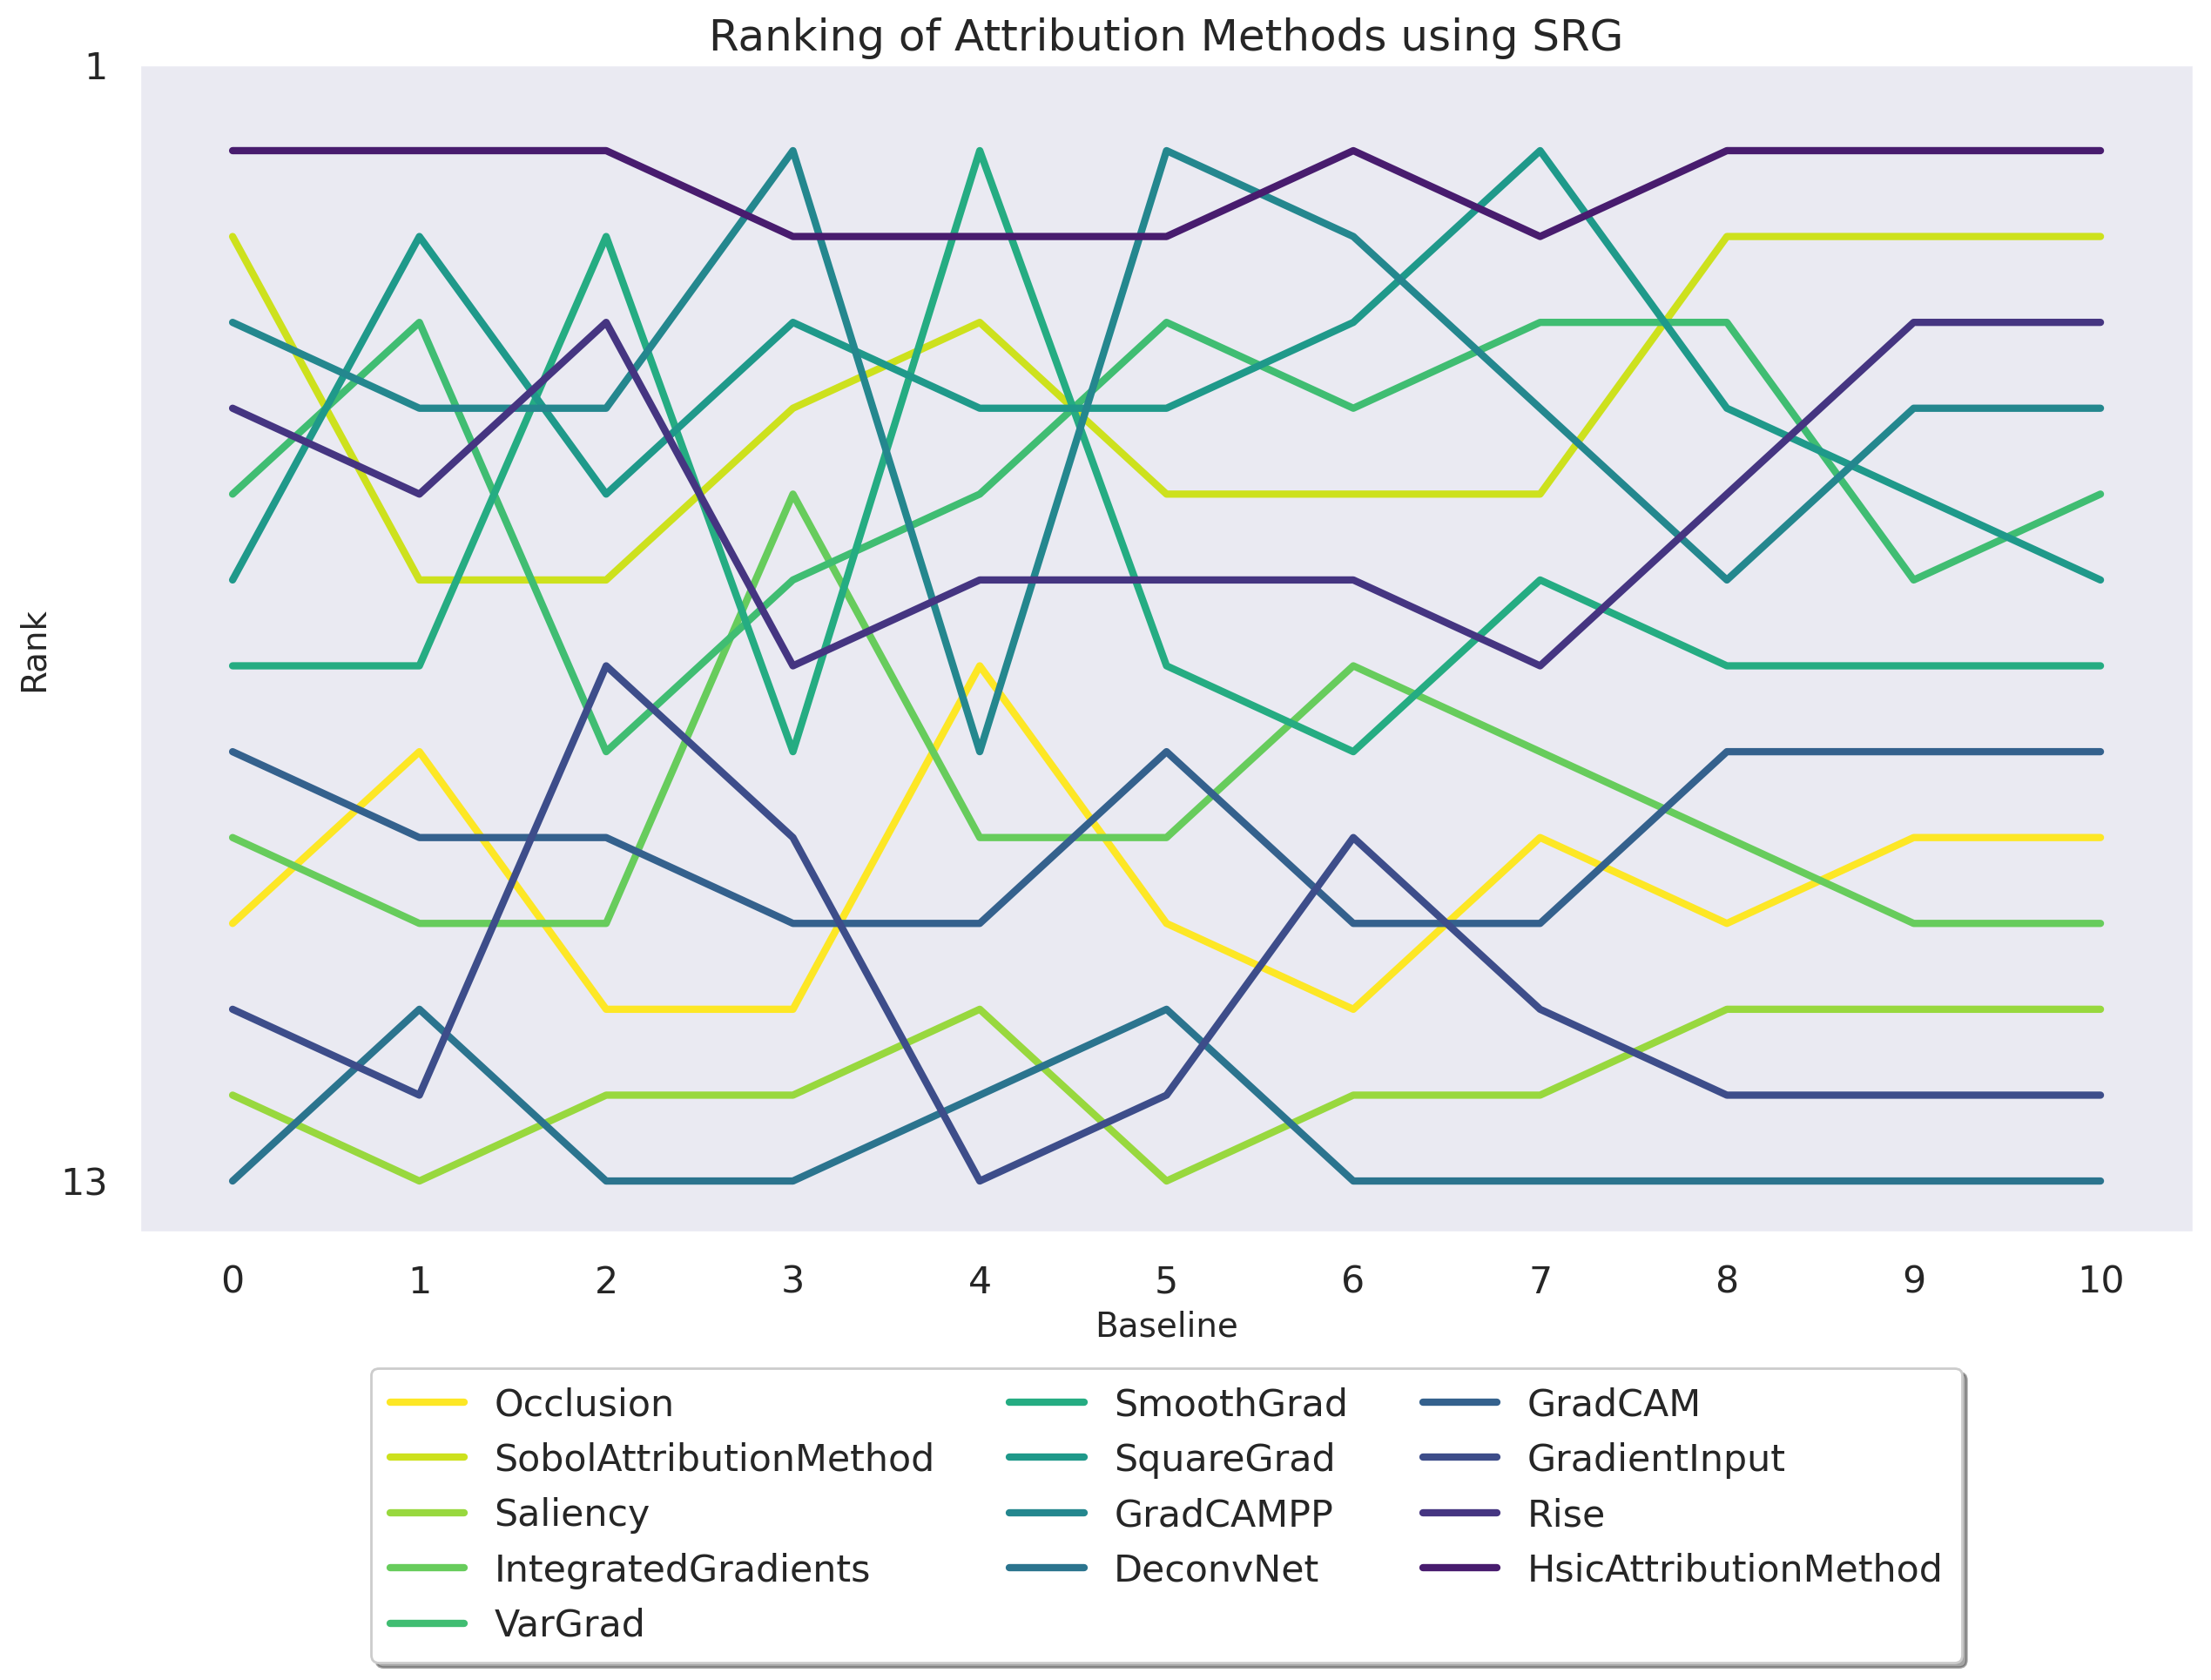

In [29]:
plot_rankings_custom(german_metrics)